## Problem Description

A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully complete some courses conducted by the company. Many people signup for their training. They want to know which of these candidates really want to work for the company after training or look for new employment. They are interested in reducing the cost and time for planning the courses and categorization of candidates. Information related to demographics, education, experience are collected from the candidates at the time of enrollment

## Data Description

+ enrollee_id : Unique ID for candidate

+ city: City code

+ city_ development _index : Developement index of the city (scaled)

+ gender: Gender of candidate

+ relevent_experience: Relevant experience of candidate

+ enrolled_university: Type of University course enrolled if any

+ education_level: Education level of candidate

+ major_discipline :Education major discipline of candidate

+ experience: Candidate total experience in years

+ company_size: No of employees in current employer's company

+ company_type : Type of current employer

+ lastnewjob: Difference in years between previous job and current job

+ training_hours: training hours completed

+ target: 0 – Not looking for job change, 1 – Looking for a job change

## Workflow Summary

+ clean the data and impute missing values
+ test if the features are relevant to predict the target variable
+ build visualizations
+ encode categorical and ordinal variables
+ handle class imbalance
+ build model
+ evaluate model
+ make predictions

In [1]:
import os
import numpy as np 
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading relevant data from the files
hr_train=pd.read_csv('aug_train.csv')
hr_test=pd.read_csv('aug_test.csv')
hr_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
print(f'Train_shape: {hr_train.shape}')
print(f'Test_shape:  {hr_test.shape}')

Train_shape: (19158, 14)
Test_shape:  (2129, 13)


## Data Preparation

In [4]:
# Finding columns with missing values
hr_train.columns[hr_train.isnull().sum()!=0]

Index(['gender', 'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job'],
      dtype='object')

#### Enrolee ID

In [5]:
hr_train['enrollee_id'].nunique()

19158

Enrollee ID has no useful information and can be dropped. I'll set it as index column

In [6]:
hr_train.set_index('enrollee_id',inplace=True)
hr_test.set_index('enrollee_id',inplace=True)

#### Gender

In [7]:
hr_train['gender'].value_counts(normalize=True)

Male      0.902457
Female    0.084505
Other     0.013038
Name: gender, dtype: float64

90% values in this column is Male. So all missing values will be assumed to be Male

In [8]:
hr_train['gender'].fillna('Male',inplace=True)
hr_test['gender'].fillna('Male',inplace=True)

#### Enrolled University

In [9]:
hr_train['enrolled_university'].value_counts(normalize=True)

no_enrollment       0.736043
Full time course    0.200139
Part time course    0.063818
Name: enrolled_university, dtype: float64

73% values in this column is no_enrollment. So missing values will be imputed with this value

In [10]:
hr_train['enrolled_university'].fillna('no_enrollment',inplace=True)
hr_test['enrolled_university'].fillna('no_enrollment',inplace=True)

#### Education level

In [11]:
hr_train['education_level'].value_counts(normalize=True)

Graduate          0.620280
Masters           0.233234
High School       0.107872
Phd               0.022141
Primary School    0.016472
Name: education_level, dtype: float64

here, the levels are more distributed, so missing values will be filled with nearest valid observation

In [12]:
hr_train['education_level'].fillna(method='ffill',inplace=True)
hr_test['education_level'].fillna(method='ffill',inplace=True)

#### Major Discipline

In [13]:
hr_train['major_discipline'].value_counts(normalize=True)

STEM               0.886632
Humanities         0.040930
Other              0.023310
Business Degree    0.020006
Arts               0.015479
No Major           0.013643
Name: major_discipline, dtype: float64

 88% values here are STEM. Same will be used for imputing missing values

In [14]:
hr_train['major_discipline'].fillna('STEM',inplace=True)
hr_test['major_discipline'].fillna('STEM',inplace=True)

#### experience

In [15]:
hr_train['experience'].value_counts(normalize=True)

>20    0.172105
5      0.074897
4      0.073482
3      0.070916
6      0.063688
2      0.059027
7      0.053842
10     0.051590
9      0.051328
8      0.042005
15     0.035929
11     0.034777
14     0.030692
1      0.028754
<1     0.027340
16     0.026607
12     0.025873
13     0.020898
17     0.017912
19     0.015922
18     0.014665
20     0.007752
Name: experience, dtype: float64

Observations are spread among different classes. Nearest value will be used to impute missing values

In [16]:
hr_train['experience'].fillna(method='ffill',inplace=True)
hr_test['experience'].fillna(method='ffill',inplace=True)

In [17]:
#### Company Size
hr_train['company_size'].value_counts(normalize=True)

50-99        0.233207
100-500      0.194478
10000+       0.152723
10/49        0.111271
1000-4999    0.100454
<10          0.098941
500-999      0.066339
5000-9999    0.042587
Name: company_size, dtype: float64

Nearest value will be used to fill missing observations

In [18]:
hr_train['company_size'].fillna(method='bfill',inplace=True)
hr_test['company_size'].fillna(method='bfill',inplace=True)

#### company_type

In [19]:
hr_train['company_type'].value_counts(normalize=True)

Pvt Ltd                0.754110
Funded Startup         0.076894
Public Sector          0.073360
Early Stage Startup    0.046320
NGO                    0.040022
Other                  0.009295
Name: company_type, dtype: float64

In [20]:
hr_train['company_type'].fillna('Pvt Ltd',inplace=True)
hr_test['company_type'].fillna('Pvt Ltd',inplace=True)

#### last new job

In [21]:
hr_train['last_new_job'].value_counts(normalize=True)

1        0.429143
>4       0.175607
2        0.154790
never    0.130878
4        0.054924
3        0.054657
Name: last_new_job, dtype: float64

In [22]:
hr_train['last_new_job'].fillna(method='ffill',inplace=True)
hr_test['last_new_job'].fillna(method='ffill',inplace=True)

In [23]:
hr_train.dropna(inplace=True)
hr_train.isnull().sum()

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

## EDA

In [24]:
hr_train.describe(include='all')

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
count,19157,19157.000000,19157,19157,19157,19157,19157,19157,19157,19157,19157,19157.000000,19157.000000
unique,123,NaN,3,2,3,5,6,22,8,6,6,NaN,NaN
top,city_103,NaN,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,NaN,NaN
freq,4355,NaN,17728,13792,14202,11890,17304,3294,4457,15956,8216,NaN,NaN
mean,NaN,0.828847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.363679,0.249361
std,NaN,0.123365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.058379,0.432654
min,NaN,0.448000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,NaN,0.740000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,0.000000
50%,NaN,0.903000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.000000,0.000000
75%,NaN,0.920000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.000000,0.000000


#### Computing measure of association between different categorical columns and the target

In [25]:

target=hr_train['target'].copy()
def test_chi2(col1,col2=target,df=hr_train,alpha=0.05):
    '''Function to test chi2 independence between 2 categorical columns'''
    '''expects a dataframe and the names of 2 categorical columns'''
    '''alpha is the level of significance and is set to 0.05 by default'''
    '''Returns True if the columns are associated else returns False'''
    
    tab1=df.groupby([col2,col1]).count().iloc[:,0].reset_index(name='count')
    t1=tab1.pivot_table(index=col1,columns=col2,values='count').fillna(0)
    p_comp=chi2_contingency(t1)[1]
    if p_comp<=alpha:
        return True
    else:
        return False


In [26]:
## seggregating columns into numeric, ordinal and categorical types

num_cols=list(hr_train.select_dtypes(include=['int64','float64']).dtypes.index)
ord_cols=np.array(['experience','education_level','company_size','last_new_job'])
cat_cols=np.array([x for x in hr_train.columns if x not in num_cols and x not in ord_cols])

#### Checking association between numeric columns and target

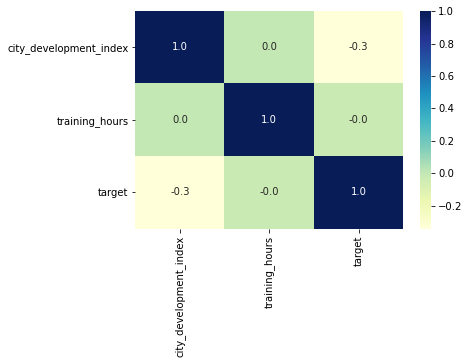

In [27]:
c1=hr_train[num_cols].corr()
sns.heatmap(c1,annot=True,fmt='0.1f',cmap='YlGnBu');

In [28]:
hr_train['target']=hr_train['target'].astype('category')

Text(0.5, 1.0, 'Distribution of training hours for both actegories')

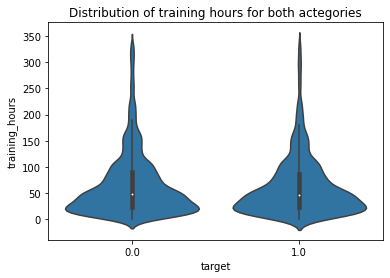

In [29]:
# visualizing training hour distribution for both classes
base_color=sns.color_palette()[0]
sns.violinplot(data=hr_train,y='training_hours',x='target',color=base_color);
plt.title('Distribution of training hours for both actegories')

It can be seen that the distribution of training hours is exactly the same for both categories. Hence Training hours can be dropped

In [30]:
# Removing target and number of training hours from list of numeric columns
num_cols=['city_development_index']

In [31]:
# Selecting features from ordinal columns
supp_vec_ord=[test_chi2(x) for x in ord_cols]
ord_cols=ord_cols[supp_vec_ord]

# selecting features from categorical columns
supp_vec_cat=[test_chi2(x) for x in cat_cols]
cat_cols=cat_cols[supp_vec_cat]

print('Ordinal columns selected: ',ord_cols)
print(' ')
print('cardinal columns selected: ',cat_cols)

Ordinal columns selected:  ['experience' 'education_level' 'company_size' 'last_new_job']
 
cardinal columns selected:  ['city' 'gender' 'relevent_experience' 'enrolled_university'
 'major_discipline' 'company_type']


In [32]:
# checking cardinality of the categorical columns
for col in cat_cols:
    print(f'{col}: {hr_train[col].nunique()}')

city: 123
gender: 3
relevent_experience: 2
enrolled_university: 3
major_discipline: 6
company_type: 6


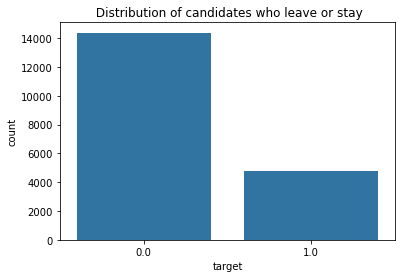

In [33]:
# Checking distribution of the target column
base_color=sns.color_palette()[0]
sns.countplot(hr_train['target'],color=base_color)
plt.title(' Distribution of candidates who leave or stay');


#### plotting categorical variables

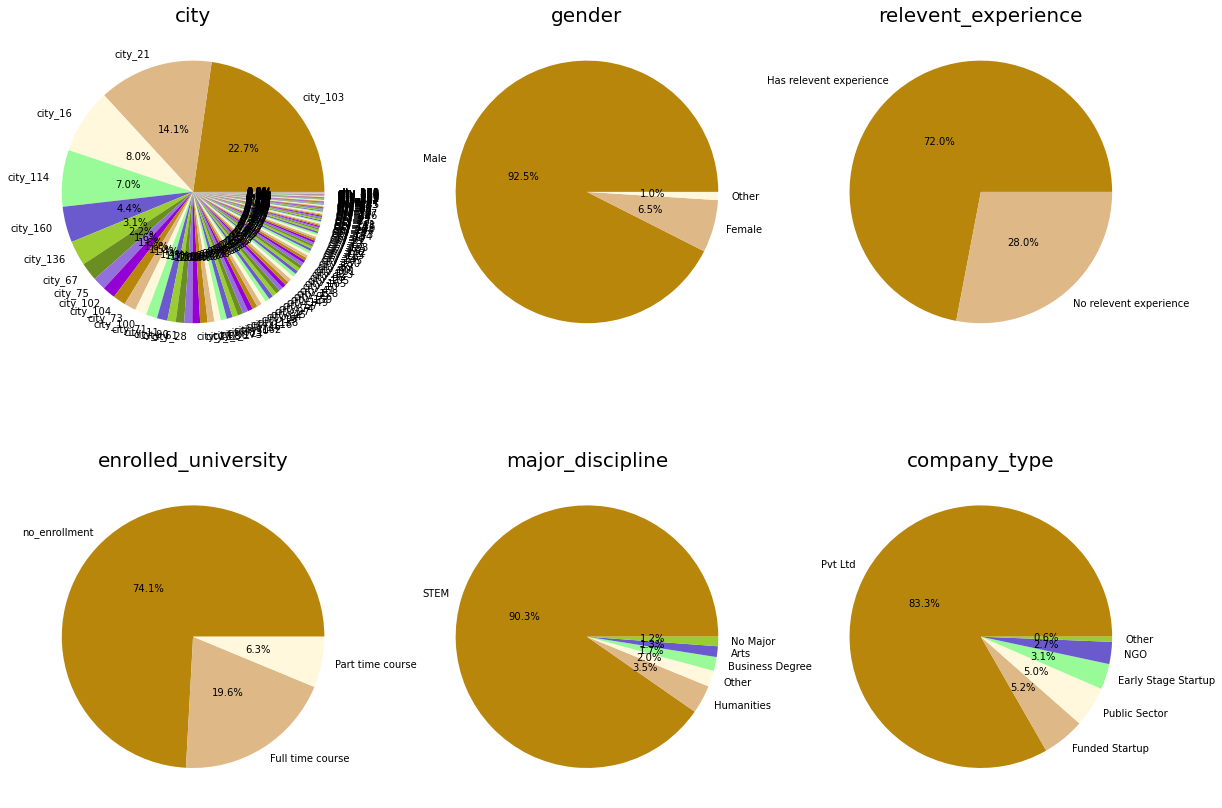

In [34]:
i=1
plt.figure(figsize=(20,15))
col1=['darkgoldenrod','burlywood','cornsilk','palegreen','slateblue',
      'yellowgreen','olivedrab','mediumpurple','darkviolet']
for col in cat_cols:
    plt.subplot(2,3,i)
    labels=list(hr_train[col].value_counts().index)
    values=list(hr_train[col].value_counts().values)
    plt.pie(x=values,autopct='%.1f%%',labels=labels,pctdistance=0.5,colors=col1)
    plt.title(col,fontsize=20)
    i+=1

#### plotting ordinal variables 

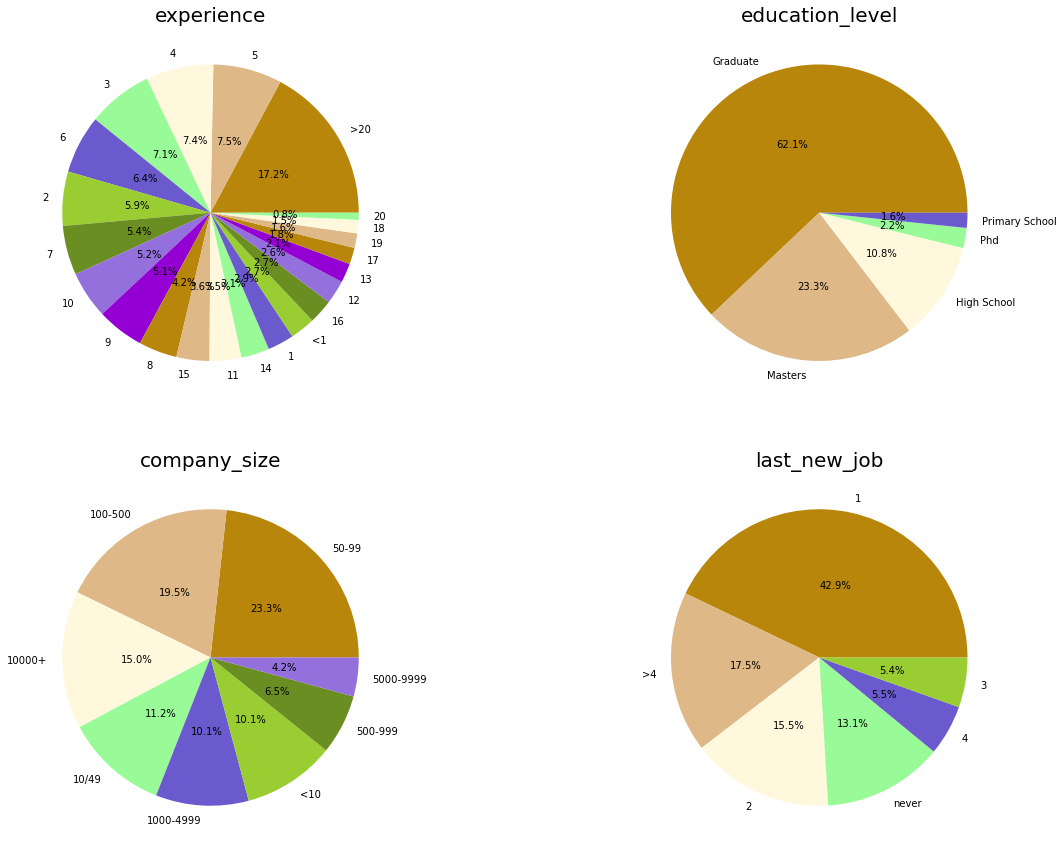

In [35]:
i=1
plt.figure(figsize=(20,15))

for col in ord_cols:
    plt.subplot(2,2,i)
    labels=list(hr_train[col].value_counts().index)
    values=list(hr_train[col].value_counts().values)
    plt.pie(x=values,autopct='%.1f%%',labels=labels,pctdistance=0.5,colors=col1)
    plt.title(col,fontsize=20)
    i+=1

##### City development index vs Attrition

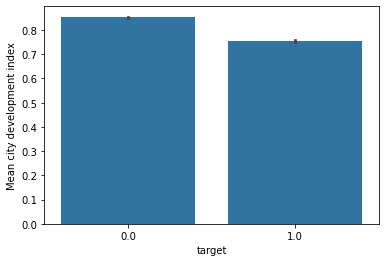

In [36]:
sns.barplot(data=hr_train,x='target',y='city_development_index',color=base_color,estimator=np.mean);
plt.ylabel('Mean city development index');

It can be seen that candidates from more developed cities tend to stay

#####  Company size vs Attrition

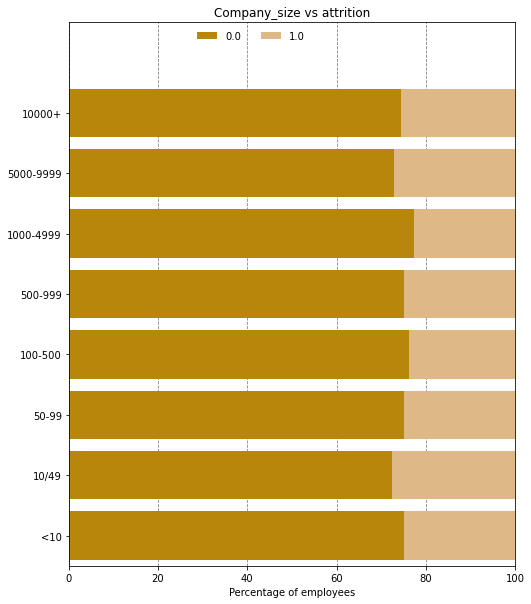

In [37]:
or1=['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
size_class=CategoricalDtype(ordered=True,categories=or1)

hr_train['company_size']=hr_train['company_size'].astype(size_class)

t1=hr_train.groupby(['target','company_size']).count().iloc[:,0].reset_index(name='count')
t1=t1.pivot_table(columns='target',index='company_size',values='count')

# converting values in pivot table to percentages
for x in t1.index:
    t1.loc[x,:]=np.round(100*t1.loc[x,:]/t1.loc[x,:].sum(axis=0),2)
t1.fillna(0,inplace=True)


fig,ax=plt.subplots(1,figsize=(8,10))
left=len(t1)*[0]  # setting the location for left end of the bars

for idx,name in enumerate(t1.columns):
    plt.barh(t1.index,t1[name],color=col1[idx],left=left)
    left+=t1[name]
plt.legend(t1.columns.tolist(),bbox_to_anchor=([0.55, 1, 0, 0]),ncol=3,frameon=False)
plt.xlabel('Percentage of employees')
plt.title('Company_size vs attrition')

# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 1.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.autoscale(enable=True, axis='x', tight=True)

It can be seen that mid size companies have higher attrition rates than smaller and larger companies

##### Education level vs Attrition

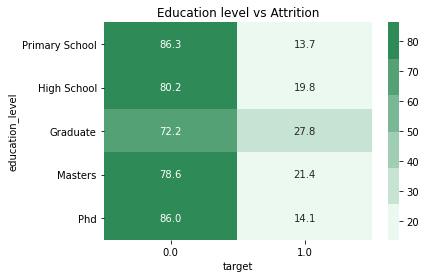

In [38]:
edu_level=['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
edu_class=CategoricalDtype(ordered=True,categories=edu_level)
hr_train['education_level']=hr_train['education_level'].astype(edu_class)

t1=hr_train.groupby(['target','education_level']).count().iloc[:,0].reset_index(name='count')
t1=t1.pivot_table(columns='target',index='education_level',values='count')

# converting values in pivot table to percentages
for x in t1.index:
    t1.loc[x,:]=np.round(100*t1.loc[x,:]/t1.loc[x,:].sum(axis=0),2)
t1.fillna(0,inplace=True)

cm1=sns.light_palette('seagreen')
sns.heatmap(t1,fmt='0.1f',annot=True,cmap=cm1)
plt.title('Education level vs Attrition');

It appears that people have having bachelor's or master's degrees have highest chance of leaving the company

##### last new job vs attrition

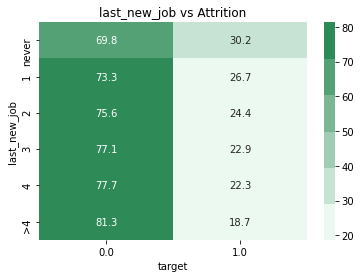

In [39]:

exp_level=['never', '1', '2', '3', '4', '>4']
exp_class=CategoricalDtype(ordered=True,categories=exp_level)
hr_train['last_new_job']=hr_train['last_new_job'].astype(exp_class)

t1=hr_train.groupby(['target','last_new_job']).count().iloc[:,0].reset_index(name='count')
t1=t1.pivot_table(columns='target',index='last_new_job',values='count')

# converting values in pivot table to percentages
for x in t1.index:
    t1.loc[x,:]=np.round(100*t1.loc[x,:]/t1.loc[x,:].sum(axis=0),2)
t1.fillna(0,inplace=True)

cm1=sns.light_palette('seagreen')
sns.heatmap(t1,fmt='0.1f',annot=True,cmap=cm1)
plt.title('last_new_job vs Attrition');

It can been that attrition rate is highest among freshers. This can be because of freshers being unsure of their career path and aspirations

##### Years of experience vs attrition

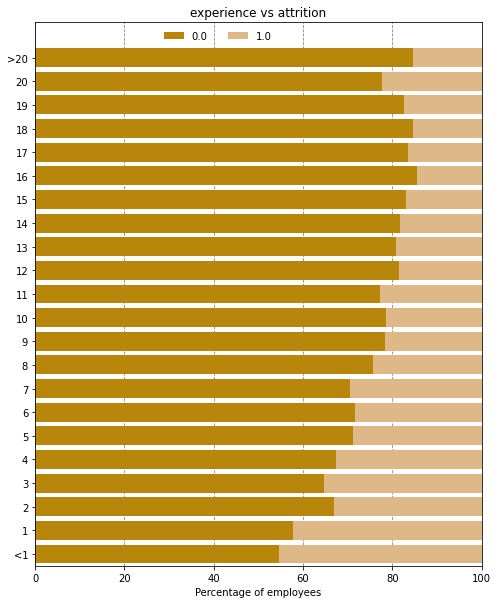

In [40]:

exp_order=['<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                      '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']
exp_class=CategoricalDtype(ordered=True,categories=exp_order)
hr_train['experience']=hr_train['experience'].astype(exp_class)

t1=hr_train.groupby(['target','experience']).count().iloc[:,0].reset_index(name='count')
t1=t1.pivot_table(columns='target',index='experience',values='count')

# converting values in pivot table to percentages
for x in t1.index:
    t1.loc[x,:]=np.round(100*t1.loc[x,:]/t1.loc[x,:].sum(axis=0),2)
t1.fillna(0,inplace=True)

fig,ax=plt.subplots(1,figsize=(8,10))
left=len(t1)*[0]  # setting the location for left end of the bars

for idx,name in enumerate(t1.columns):
    plt.barh(t1.index,t1[name],color=col1[idx],left=left)
    left+=t1[name]
plt.legend(t1.columns.tolist(),bbox_to_anchor=([0.55, 1, 0, 0]),ncol=3,frameon=False)
plt.xlabel('Percentage of employees')
plt.title('experience vs attrition')

# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 1.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.autoscale(enable=True, axis='x', tight=True)

As can be seen, people with low experience tend to leave more. 

### Encoding

#### OneHot encoding

In [301]:
oh1=OneHotEncoder(handle_unknown='ignore')
train_cat=oh1.fit_transform(hr_train[cat_cols])
test_cat=oh1.transform(hr_test[cat_cols])
f_names=[j for i in oh1.categories_ for j in i]


#### Ordinal encoding

In [302]:
# Experience
ordinal_experience = {'<1':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10,
                      '11':11, '12':12, '13':13, '14':14, '15':15, '16':16, '17':17, '18':18, '19':19, '20':20, '>20':21}
hr_train['experience']=hr_train['experience'].map(ordinal_experience)
hr_test['experience']=hr_test['experience'].map(ordinal_experience)

In [303]:
# company size
ordinal_company_size = {'<10':0, '10/49':1, '50-99':2, '100-500':3, '500-999':4, '1000-4999':5, '5000-9999':6, '10000+':7}
hr_train['company_size']=hr_train['company_size'].map(ordinal_company_size)
hr_test['company_size']=hr_test['company_size'].map(ordinal_company_size)

In [304]:
##education level
ordinal_education_level = {'Primary School':0, 'High School':1, 'Graduate':2, 'Masters':3, 'Phd':4}
hr_train['education_level']=hr_train['education_level'].map(ordinal_education_level)
hr_test['education_level']=hr_test['education_level'].map(ordinal_education_level)

In [305]:
## last_new_job
ordinal_last_new_job = {'never':0, '1':1, '2':2, '3':3, '4':4, '>4':5}
hr_train['last_new_job']=hr_train['last_new_job'].map(ordinal_last_new_job)
hr_test['last_new_job']=hr_test['last_new_job'].map(ordinal_last_new_job)

In [306]:
ms=MinMaxScaler()
train_ord=ms.fit_transform(hr_train[ord_cols])
test_ord=ms.transform(hr_test[ord_cols])

#### Numeric variables

In [307]:
train_num=ms.fit_transform(hr_train[num_cols])
test_num=ms.transform(hr_test[num_cols])

In [309]:
#Joining the arrays 
feature_names=f_names+list(ord_cols)+list(num_cols)

X=np.concatenate([train_cat.toarray(),train_ord,train_num],axis=1)
y=hr_train['target']

features_test=np.concatenate([test_cat.toarray(),test_ord,test_num],axis=1)



#### Upsampling and train-test-split

In [310]:
sm=SMOTE(random_state=21)
X,y=sm.fit_resample(X,y)

In [311]:
#Train-test-split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.9,random_state=23)

### Model Building

In [312]:
# Baseline model
lr1=LogisticRegression()
lr1.fit(X_train,y_train)
pred=lr1.predict(X_test)
print(f1_score(y_test,pred))

0.6846433192803774


In [313]:
# Random Forest classifier
rf=RandomForestClassifier(random_state=23,n_jobs=3)

kf=KFold(n_splits=5,shuffle=True,random_state=23)
p_grid={'n_estimators':[300,600],
            'max_depth':[5,7,9],
            'max_features':[0.2,0.6],
            'min_samples_leaf':[5,7,11]
           }
rf_grid=RandomizedSearchCV(rf,param_distributions=p_grid,cv=kf)

In [314]:
%%time
rf_grid.fit(X_train,y_train)

Wall time: 1min 12s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=3, random_state=23),
                   param_distributions={'max_depth': [5, 7, 9],
                                        'max_features': [0.2, 0.6],
                                        'min_samples_leaf': [5, 7, 11],
                                        'n_estimators': [300, 600]})

In [315]:
rf_grid.best_params_

{'n_estimators': 600,
 'min_samples_leaf': 7,
 'max_features': 0.6,
 'max_depth': 9}

In [316]:
pred=rf_grid.predict(X_test)
f1_score(y_test,pred)

0.741065464261857

In [317]:
## catboost
params = {
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [318]:
xgb = CatBoostClassifier(learning_rate=0.02, n_estimators=600, verbose = False)

In [321]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=42)


In [322]:
%%time
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   14.7s finished


Wall time: 16.9 s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001D9CE7ABE48>,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001D9D4A2F688>,
                   n_iter=5, n_jobs=4,
                   param_distributions={'max_depth': [3, 4, 5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [323]:
random_search.best_params_

{'subsample': 1.0, 'max_depth': 5}

In [324]:
model = CatBoostClassifier(learning_rate=0.02, n_estimators=600, verbose = False, subsample = 0.8, max_depth = 5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f1_score(y_test,y_pred))

0.8057536267519055


In [325]:
# Probabilities that a candidate will work for the company=probality of class 0
model.predict_proba(features_test)[:,0]

array([0.76069256, 0.70353607, 0.35494086, ..., 0.90202237, 0.84190658,
       0.82520068])

In [326]:
# Feature Importances
f_importances=pd.DataFrame()
f_importances['feature_names']=feature_names
f_importances['Coefficients']=model.feature_importances_
f_importances=f_importances.sort_values(by='Coefficients',ascending=True).set_index('feature_names')


Text(0.5, 0, 'Feature Importances')

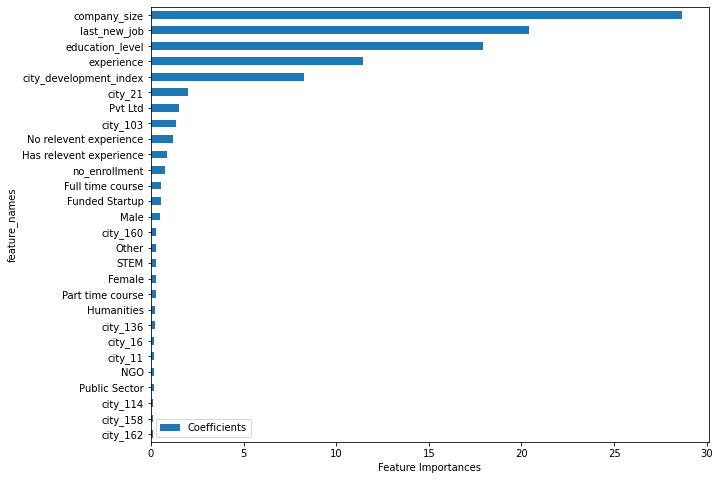

In [327]:
f_importances[f_importances['Coefficients']>=0.1].plot.barh(figsize=(10,8))
plt.xlabel('Feature Importances')


## Therefore top 5 factors pertaining to employee retainment are
+ company size  
people from midsize companies tend to leave more than really small or really big companies  

+ years since last new job  
Freshers have the highest attrition rate. People who settle into the job tend to stay

+ education level  
Here again,there's atrend of mid level people leaving. People with bachelor's or masters degrees have highest attrition rates

+ experience  
People with low experience/freshers tend to leave more

+ City development index  
People from more developed cities tend to leave less
